# Import essential libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
import pyLDAvis.sklearn
from statsmodels.tsa.stattools import grangercausalitytests

/home/saras/anaconda3/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [2]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.decomposition._online_lda_fast import _dirichlet_expectation_2d
class PTW_LDA(LatentDirichletAllocation):

    def __init__(self, n_components=10, *, doc_topic_prior=None,
                 topic_word_prior=None, learning_method='batch',
                 learning_decay=.7, learning_offset=10., max_iter=10,
                 batch_size=128, evaluate_every=-1, total_samples=1e6,
                 perp_tol=1e-1, mean_change_tol=1e-3, max_doc_update_iter=100,
                 n_jobs=None, verbose=0, random_state=None, 
                 ptws=None):
        super(PTW_LDA, self).__init__(n_components, doc_topic_prior, topic_word_prior, 
                                      learning_method, learning_decay, learning_offset, 
                                      max_iter, batch_size, evaluate_every, total_samples, 
                                      perp_tol, mean_change_tol, max_doc_update_iter, 
                                      n_jobs, verbose, random_state)
        self.ptws = ptws

    def _init_latent_vars(self, n_features):
        """Initialize latent variables."""

        self.random_state_ = check_random_state(self.random_state)
        self.n_batch_iter_ = 1
        self.n_iter_ = 0

        if self.doc_topic_prior is None:
            self.doc_topic_prior_ = 1. / self.n_components
        else:
            self.doc_topic_prior_ = self.doc_topic_prior

        if self.topic_word_prior is None:
            self.topic_word_prior_ = 1. / self.n_components
        else:
            self.topic_word_prior_ = self.topic_word_prior

        init_gamma = 100.
        init_var = 1. / init_gamma
        # In the literature, this is called `lambda`
        self.components_ = self.random_state_.gamma(
            init_gamma, init_var, (self.n_components, n_features))

        # Transform topic values in matrix for prior topic words
        if self.ptws is not None:
            for ptw in self.ptws:
                word_index = ptw[0]
                word_topic_values = ptw[1]
                self.components_[:, word_index] *= word_topic_values

        # In the literature, this is `exp(E[log(beta)])`
        self.exp_dirichlet_component_ = np.exp(
            _dirichlet_expectation_2d(self.components_))

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def lemma_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Merge NYT data
main_df = pd.read_csv('NYT2000_1.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
temp_df = pd.read_csv('NYT2000_2.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
main_df = pd.concat([main_df,temp_df], ignore_index=True)

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Remove NaN values, lowercase contents of Body column, filters for bush and gore and resets the index
main_df.dropna(subset=['Body'], inplace=True)
main_df['Body'] = main_df['Body'].str.lower()
main_df = main_df[main_df['Body'].str.contains('gore|bush')]
main_df = main_df.reset_index(drop=True)

print(main_df.shape)
print(main_df['Body'].head(10))

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4706, 4)
0    just before the july 4 recess, a senate commit...
1    george w. bush -- pittsburgh and east brunswic...
2    drivers have been paying almost twice as much ...
3    for farmers, the months leading to harvest tim...
4    international a3-13 u.s. and vietnam reach bro...
5    dna test fails to exonerate prisoner given sta...
6    former senator bill bradley made it official t...
7    from his opening salutation ''i am a member of...
8    the democratic national committee's new televi...
9    several homeowners, cell phones at hand, tend ...
Name: Body, dtype: object


In [6]:
# Create a single date column from day, month and year columns
main_df['Date'] = pd.to_datetime(
    main_df['Publication Year'] * 10000 + main_df['Publication Month'] * 100 + main_df['Publication Day Of Month'],
    format='%Y%m%d')
main_df.drop(['Publication Year', 'Publication Month', 'Publication Day Of Month'], axis=1, inplace=True)

print(main_df.head(10))

                                                Body       Date
0  just before the july 4 recess, a senate commit... 2000-07-13
1  george w. bush -- pittsburgh and east brunswic... 2000-07-13
2  drivers have been paying almost twice as much ... 2000-07-13
3  for farmers, the months leading to harvest tim... 2000-07-13
4  international a3-13 u.s. and vietnam reach bro... 2000-07-13
5  dna test fails to exonerate prisoner given sta... 2000-07-13
6  former senator bill bradley made it official t... 2000-07-13
7  from his opening salutation ''i am a member of... 2000-07-13
8  the democratic national committee's new televi... 2000-07-13
9  several homeowners, cell phones at hand, tend ... 2000-07-13


/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Remove unnecessary symbols, numbers, words less than 3 characters and apply lemmatizer
main_df['Body'].replace([r'[,\.!?]', r'\d+', r'\b(\w{1,2})\b'], '', inplace=True, regex=True)
main_df['Body'].apply(lemma_text)
main_df['Body'] = main_df['Body'].str.replace('said', '', regex=False)

print(main_df.head(10))

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                                Body       Date
0  just before the july  recess  senate committee... 2000-07-13
1  george  bush -- pittsburgh and east brunswick ... 2000-07-13
2  drivers have been paying almost twice  much fo... 2000-07-13
3  for farmers the months leading  harvest time a... 2000-07-13
4  international -  and vietnam reach broad trade... 2000-07-13
5  dna test fails  exonerate prisoner given stay ... 2000-07-13
6  former senator bill bradley made  official tod... 2000-07-13
7  from his opening salutation ''   member  the n... 2000-07-13
8  the democratic national committee' new televis... 2000-07-13
9  several homeowners cell phones  hand tend thei... 2000-07-13


In [8]:
#Read the IEM data and Normalize one of the stocks
iem_data = pd.read_excel('IEM2000.xlsx')
iem_data.drop(['Units', '$Volume', 'LowPrice','HighPrice','AvgPrice'], axis=1, inplace=True)

dem_data = iem_data[iem_data['Contract'].str.contains('Dem')]
rep_data = iem_data[iem_data['Contract'].str.contains('Rep')]

dem_data.set_index('Date', inplace=True)
rep_data.set_index('Date', inplace=True)

dem_data['NormLastPrice'] = dem_data['LastPrice'] / (dem_data['LastPrice'] + rep_data['LastPrice'])
dem_data.drop(['LastPrice', 'Contract'], axis=1, inplace=True)

print(dem_data.head())

            NormLastPrice
Date                     
2000-05-01       0.523810
2000-05-02       0.504970
2000-05-03       0.509491
2000-05-04       0.511466
2000-05-05       0.520875


/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/saras/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/saras/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/saras/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method

In [9]:
# Generate feature vector and document vs. term matrix
# Note: the individual matrix values are term frequencies for each document
cv = CountVectorizer(stop_words='english', max_df=3500)
ft_cv = cv.fit_transform(main_df['Body'])
vocabulary = cv.get_feature_names()
doc_term_matrix = pd.DataFrame(ft_cv.toarray(), columns=vocabulary)

print(doc_term_matrix.shape)
print(doc_term_matrix.head())

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4706, 63104)
   aaa  aab  aabb  aachen  aakporg  aalto  aan  aardvark  aaron  aaronson  \
0    0    0     0       0        0      0    0         0      0         0   
1    0    0     0       0        0      0    0         0      0         0   
2    0    0     0       0        0      0    0         0      0         0   
3    0    0     0       0        0      0    0         0      0         0   
4    0    0     0       0        0      0    0         0      0         0   

   ...  zuylen  zvi  zwerger  zwilling  zwirn  zwirner  zydeco  zygmunt  \
0  ...       0    0        0         0      0        0       0        0   
1  ...       0    0        0         0      0        0       0        0   
2  ...       0    0        0         0      0        0       0        0   
3  ...       0    0        0         0      0        0       0        0   
4  ...       0    0        0         0      0        0       0        0   

   zymogenetics  zyzzyva  
0             0        0  
1             0   

In [10]:
# Generate word stream
# Note: the individual matrix value are term frequencies for each date
doc_term_matrix['Date'] = main_df['Date']
aggregator_words = {i: 'sum' for i in vocabulary}
word_stream = doc_term_matrix.groupby(['Date']).agg(aggregator_words)

print(word_stream.shape)
print(word_stream.head())

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(194, 63104)
            aaa  aab  aabb  aachen  aakporg  aalto  aan  aardvark  aaron  \
Date                                                                       
2000-05-01    0    0     0       0        0      0    0         0      0   
2000-05-02    0    0     0       0        0      0    0         0      0   
2000-05-03    0    0     0       0        0      0    0         0      0   
2000-05-04    0    0     0       0        0      0    0         0      0   
2000-05-05    0    0     0       0        0      0    0         0      0   

            aaronson  ...  zuylen  zvi  zwerger  zwilling  zwirn  zwirner  \
Date                  ...                                                   
2000-05-01         0  ...       0    0        0         0      5        0   
2000-05-02         0  ...       0    0        0         0      0        0   
2000-05-03         0  ...       0    0        0         0      0        0   
2000-05-04         0  ...       0    0        0         2      0     

In [11]:
# Add IEM Stock data to word_stream
combined_word_dem_data = pd.concat([dem_data, word_stream], axis=1, join='inner')
print(combined_word_dem_data.head())
print(pd.date_range(start='2000-05-01',end='2000-11-10').difference(combined_word_dem_data.index))

            NormLastPrice  aaa  aab  aabb  aachen  aakporg  aalto  aan  \
Date                                                                     
2000-05-01       0.523810    0    0     0       0        0      0    0   
2000-05-02       0.504970    0    0     0       0        0      0    0   
2000-05-03       0.509491    0    0     0       0        0      0    0   
2000-05-04       0.511466    0    0     0       0        0      0    0   
2000-05-05       0.520875    0    0     0       0        0      0    0   

            aardvark  aaron  ...  zuylen  zvi  zwerger  zwilling  zwirn  \
Date                         ...                                          
2000-05-01         0      0  ...       0    0        0         0      5   
2000-05-02         0      0  ...       0    0        0         0      0   
2000-05-03         0      0  ...       0    0        0         0      0   
2000-05-04         0      0  ...       0    0        0         2      0   
2000-05-05         0      0  ..

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17574610.51125894
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.100898  0.092278  1.618739  0.524482  0.004324  2.810622   
2000-05-02  0.029518  0.018135  1.303748  0.058644  0.009597  2.938349   
2000-05-03  0.389210  0.547807  1.088005  1.029097  0.010849  4.646224   
2000-05-04  0.029233  0.125823  1.324163  0.438582  0.025282  6.606420   
2000-05-05  0.060062  0.159463  2.358398  0.675356  0.011935  2.854709   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.004250  0.197011  6.292272  0.002974  0.005923  0.430773   
2000-05-02  0.082324  0.009597  5.126515  0.009597  0.062347  0.020265   
2000-05-03  0.020596  0.417164  6.692031  0.146952  0.010849  0.021644   
2000-05-04  0.014654  0.085213  8.11

<Figure size 1152x720 with 0 Axes>

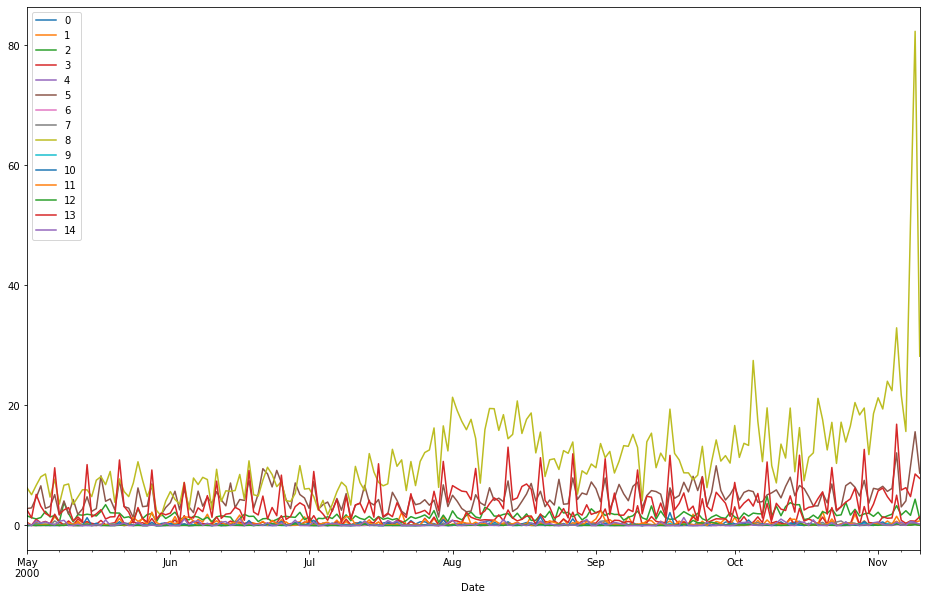

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.100898  0.092278  1.618739  0.524482  0.004324   
2000-05-02       0.504970  0.029518  0.018135  1.303748  0.058644  0.009597   
2000-05-03       0.509491  0.389210  0.547807  1.088005  1.029097  0.010849   
2000-05-04       0.511466  0.029233  0.125823  1.324163  0.438582  0.025282   
2000-05-05       0.520875  0.060062  0.159463  2.358398  0.675356  0.011935   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  2.810622  0.004250  0.197011  6.292272  0.002974  0.005923   
2000-05-02  2.938349  0.082324  0.009597  5.126515  0.009597  0.062347   
2000-05-03  4.646224  0.020596  0.417164  6.692031  0.146952  0.010849   
2000-05-04  6.606420  0.014654  0.085213  8.110310  0.234395  0.239959   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


69
[(47323, [250.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (23473, [250.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (29216, [0, 134.21922160176612, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (15159, [0, 132.87031412069857, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (34796, [0, 129.99896434423502, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (5099, [0, 102.9114999333003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (15150, [0, 0, 34.8164892727455, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (36515, [0, 0, 34.8164892727455, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (20103, [0, 0, 34.81630936381991, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (9062, [0, 0, 34.81595084009016, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (33444, [0, 0, 34.807953970464524, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (37602, [0, 0, 34.803349145229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (53681, [0, 0, 34.799026854820056, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (31948, [0, 0, 34.79566278771296, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (32663, [0, 0

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17660081.189495638
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.002974  0.034925  0.358988  2.713095  0.742511  0.060917   
2000-05-02  0.056588  0.018261  0.162716  2.486180  0.618555  0.195566   
2000-05-03  0.010849  0.114632  1.267879  2.554889  1.005787  0.150508   
2000-05-04  0.025338  0.128609  0.282080  3.672391  1.417283  0.206142   
2000-05-05  0.116398  0.060405  0.814774  2.717489  1.218533  0.250680   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  4.503617  5.870827  0.298393  0.178780  0.027666  0.008063   
2000-05-02  2.161321  4.563558  0.665311  0.009597  0.009597  0.009597   
2000-05-03  7.838125  5.918744  0.920617  0.709643  0.043816  0.066744   
2000-05-04  5.890107  7.573207  1.3

<Figure size 1152x720 with 0 Axes>

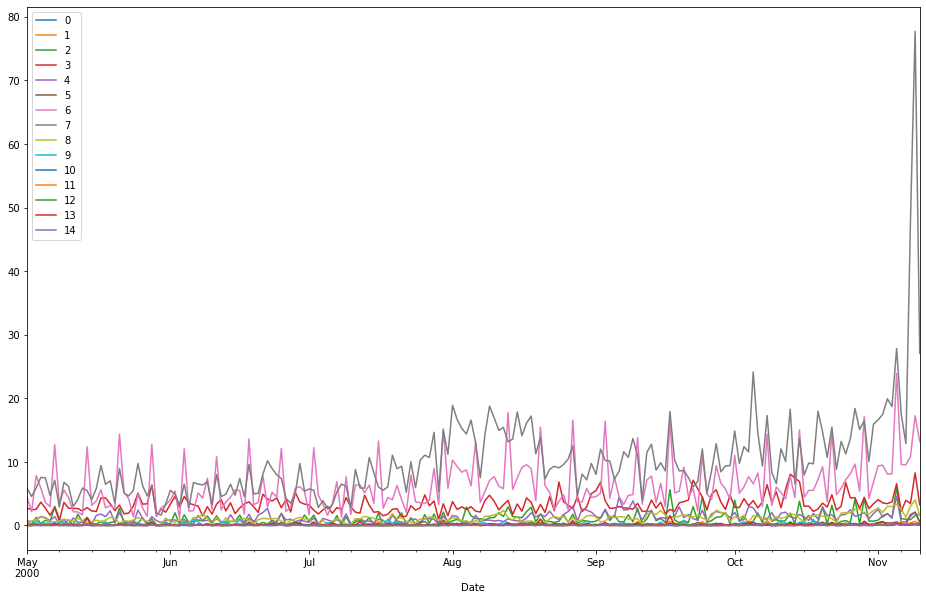

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.002974  0.034925  0.358988  2.713095  0.742511   
2000-05-02       0.504970  0.056588  0.018261  0.162716  2.486180  0.618555   
2000-05-03       0.509491  0.010849  0.114632  1.267879  2.554889  1.005787   
2000-05-04       0.511466  0.025338  0.128609  0.282080  3.672391  1.417283   
2000-05-05       0.520875  0.116398  0.060405  0.814774  2.717489  1.218533   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.060917  4.503617  5.870827  0.298393  0.178780  0.027666   
2000-05-02  0.195566  2.161321  4.563558  0.665311  0.009597  0.009597   
2000-05-03  0.150508  7.838125  5.918744  0.920617  0.709643  0.043816   
2000-05-04  0.206142  5.890107  7.573207  1.333249  0.361491  0.014654   
20

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17650649.836433336
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.012483  0.036796  1.516551  0.625048  0.008063  5.271474   
2000-05-02  0.044169  0.069047  1.600753  0.179082  0.038151  3.036225   
2000-05-03  0.069171  0.108620  1.480988  2.560776  0.026709  8.660301   
2000-05-04  0.027250  0.149846  2.834727  0.639492  0.014654  6.883281   
2000-05-05  0.013944  0.036809  1.119847  1.107337  0.013625  4.535358   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.172595  0.517313  4.777561  0.022458  1.762547  0.208873   
2000-05-02  0.043151  0.624777  4.155692  0.011597  1.117880  0.030288   
2000-05-03  0.120448  1.351988  4.988596  0.021570  1.082998  0.069009   
2000-05-04  0.092800  1.913641  6.5

<Figure size 1152x720 with 0 Axes>

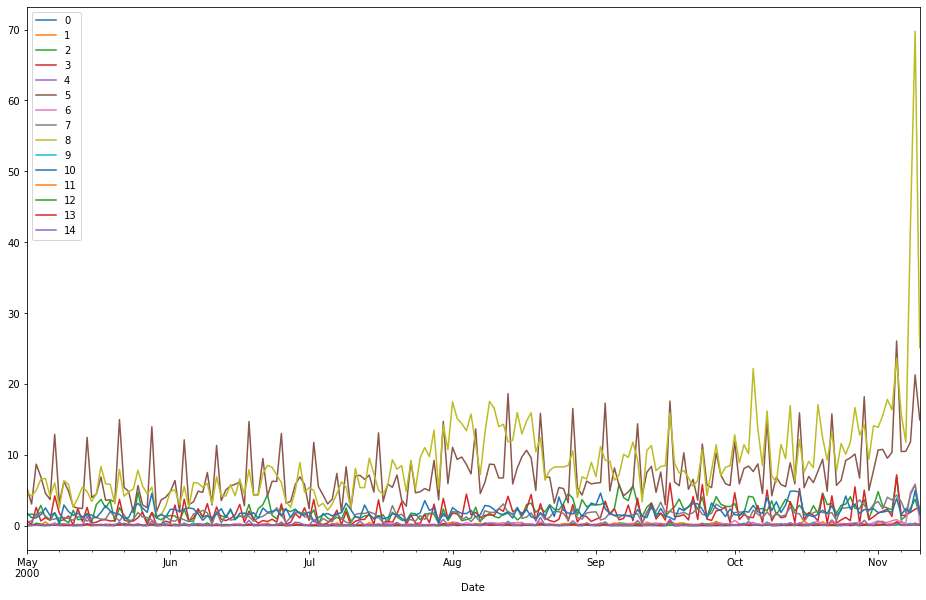

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.012483  0.036796  1.516551  0.625048  0.008063   
2000-05-02       0.504970  0.044169  0.069047  1.600753  0.179082  0.038151   
2000-05-03       0.509491  0.069171  0.108620  1.480988  2.560776  0.026709   
2000-05-04       0.511466  0.027250  0.149846  2.834727  0.639492  0.014654   
2000-05-05       0.520875  0.013944  0.036809  1.119847  1.107337  0.013625   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  5.271474  0.172595  0.517313  4.777561  0.022458  1.762547   
2000-05-02  3.036225  0.043151  0.624777  4.155692  0.011597  1.117880   
2000-05-03  8.660301  0.120448  1.351988  4.988596  0.021570  1.082998   
2000-05-04  6.883281  0.092800  1.913641  6.507305  0.014654  1.525782   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


75
[(30178, [500.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (47791, [0, 500.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62611, [0, 0, 314.52040496743723, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (33813, [0, 0, 185.4795950325628, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (41056, [0, 0, 0, 46.578606242124145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (43386, [0, 0, 0, 46.572639211431785, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (27993, [0, 0, 0, 46.56953872924621, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (37602, [0, 0, 0, 46.56184351837058, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (51934, [0, 0, 0, 46.537846547134265, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (40761, [0, 0, 0, 46.50679999420563, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (4910, [0, 0, 0, 46.49940480896406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (36049, [0, 0, 0, 46.39465506577196, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (49561, [0, 0, 0, 46.09317939546343, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (19714, [0, 0, 0, 44.97649573718188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (24951, [

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17677506.385510378
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.024224  0.042433  0.010562  2.138956  0.346974  0.022285   
2000-05-02  0.009597  0.050201  0.055205  2.377875  0.057719  0.022805   
2000-05-03  0.010849  0.054136  0.071162  2.527637  0.313994  0.270637   
2000-05-04  0.014654  0.014654  0.426806  4.558013  0.273805  0.030495   
2000-05-05  0.011935  0.205726  0.017183  2.545922  0.130387  0.029798   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  1.360818  0.079887  0.396421  7.914707  0.049781  2.379201   
2000-05-02  0.495367  0.121597  0.152955  4.624400  0.041521  2.961968   
2000-05-03  3.713198  0.169184  0.987231  7.953364  0.037409  4.155632   
2000-05-04  2.266677  0.050654  0.4

<Figure size 1152x720 with 0 Axes>

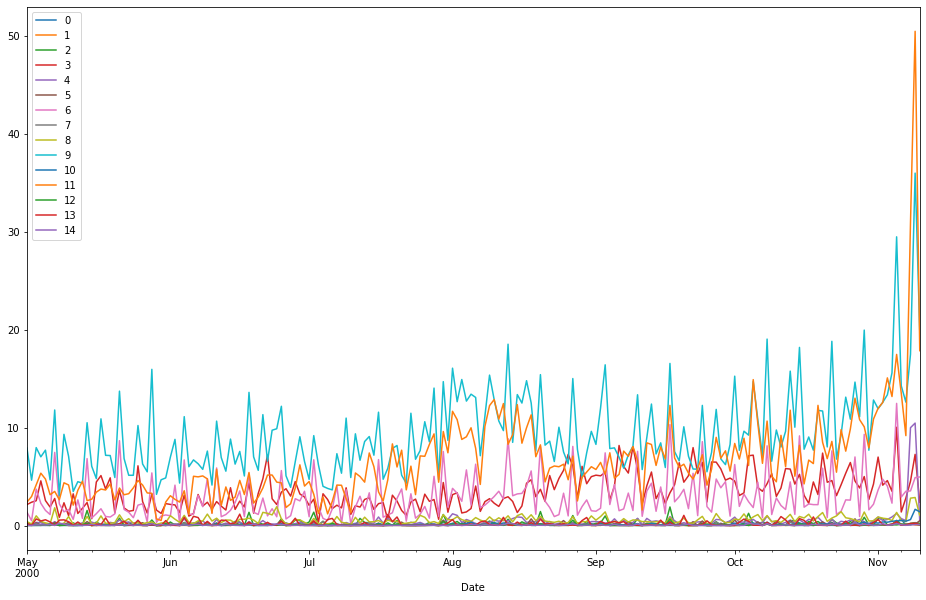

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.024224  0.042433  0.010562  2.138956  0.346974   
2000-05-02       0.504970  0.009597  0.050201  0.055205  2.377875  0.057719   
2000-05-03       0.509491  0.010849  0.054136  0.071162  2.527637  0.313994   
2000-05-04       0.511466  0.014654  0.014654  0.426806  4.558013  0.273805   
2000-05-05       0.520875  0.011935  0.205726  0.017183  2.545922  0.130387   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.022285  1.360818  0.079887  0.396421  7.914707  0.049781   
2000-05-02  0.022805  0.495367  0.121597  0.152955  4.624400  0.041521   
2000-05-03  0.270637  3.713198  0.169184  0.987231  7.953364  0.037409   
2000-05-04  0.030495  2.266677  0.050654  0.421017  7.011674  0.044009   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, bat

74
[(32894, [166.66666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61370, [166.66666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (30178, [166.66666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61429, [0, 166.66666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (13128, [0, 166.66666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (47791, [0, 166.66666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62611, [0, 0, 94.77612534114483, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (7490, [0, 0, 94.70798371716897, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (23099, [0, 0, 93.80171788101406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (5321, [0, 0, 88.42178906094824, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (55496, [0, 0, 74.297153961969, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (41988, [0, 0, 53.9952300377549, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (41056, [0, 0, 0, 57.23156970018312, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (43386, [0, 0, 0, 57.22423795368994, 0, 0, 0, 0, 0, 0, 0, 0

<Figure size 1152x720 with 0 Axes>

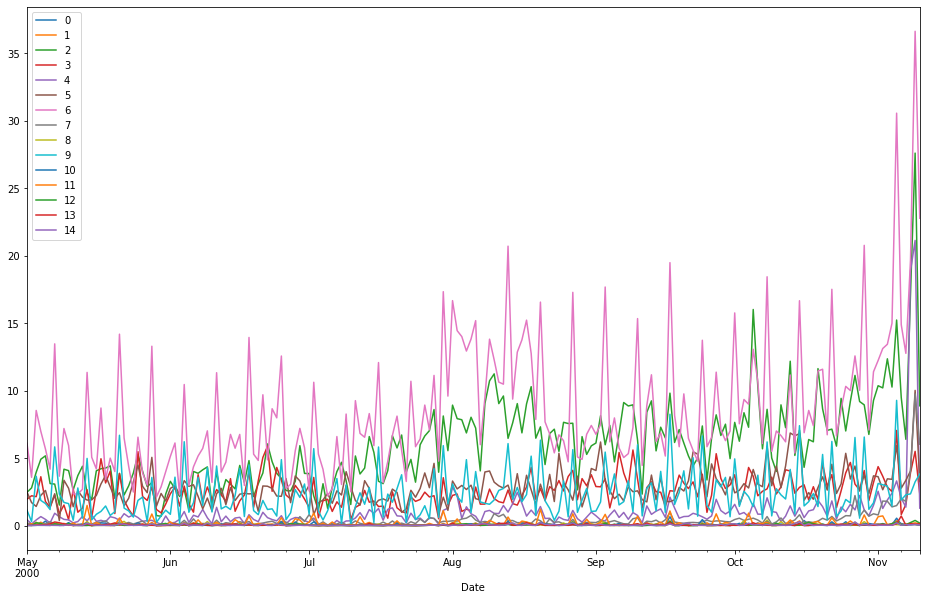

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.005670  0.112303  2.458496  1.950463  0.437983   
2000-05-02       0.504970  0.009597  0.009597  2.789113  2.204347  0.111936   
2000-05-03       0.509491  0.010849  0.225893  3.950444  2.139771  0.412120   
2000-05-04       0.511466  0.070210  0.014654  4.914375  3.615067  0.659959   
2000-05-05       0.520875  0.329659  0.088756  5.166077  1.775670  0.454191   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  2.491128  6.095684  0.186927  0.063403  1.137435  0.010837   
2000-05-02  1.699888  3.574434  0.114695  0.011869  0.297963  0.009597   
2000-05-03  1.412602  8.530440  0.154982  0.233239  3.654644  0.018534   
2000-05-04  2.234763  6.979130  0.141673  0.035226  1.860933  0.014654   
20

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17686590.748603977
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.004265  0.328262  1.721595  0.484162  0.012967  0.204087   
2000-05-02  0.128051  0.035327  1.991931  0.317339  0.019915  0.043386   
2000-05-03  0.016034  0.998475  1.676098  0.393638  0.029233  0.134966   
2000-05-04  0.059500  1.185455  3.106321  0.491576  0.068881  0.165851   
2000-05-05  0.059469  1.113111  1.213271  0.381559  0.157591  0.081680   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.092794  0.363063  7.324400  0.025033  0.871143  3.303752   
2000-05-02  0.115155  0.125741  4.399911  0.015050  0.261372  3.463598   
2000-05-03  0.184511  0.959834  8.902797  0.467745  2.555269  4.509857   
2000-05-04  0.145964  0.578881  7.3

<Figure size 1152x720 with 0 Axes>

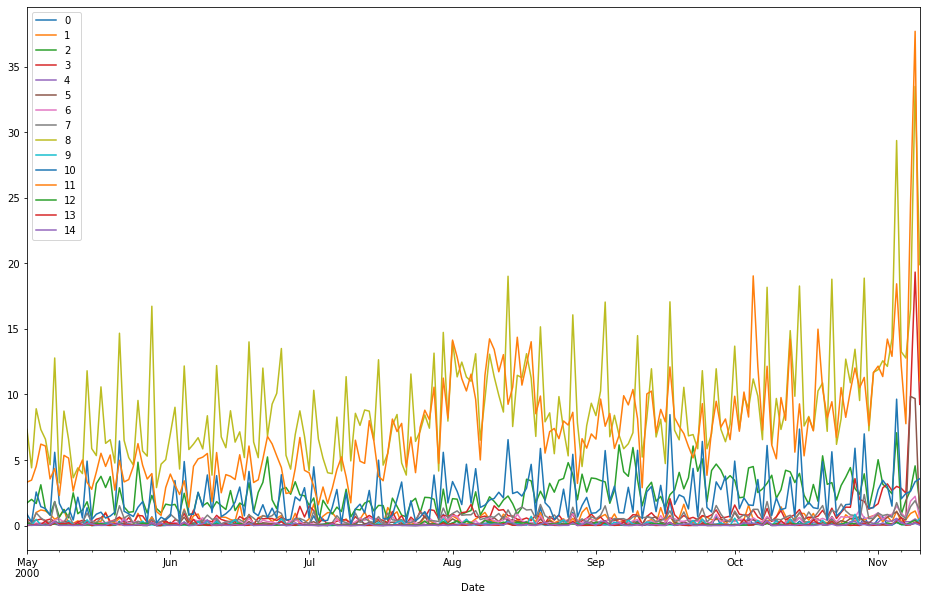

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.004265  0.328262  1.721595  0.484162  0.012967   
2000-05-02       0.504970  0.128051  0.035327  1.991931  0.317339  0.019915   
2000-05-03       0.509491  0.016034  0.998475  1.676098  0.393638  0.029233   
2000-05-04       0.511466  0.059500  1.185455  3.106321  0.491576  0.068881   
2000-05-05       0.520875  0.059469  1.113111  1.213271  0.381559  0.157591   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.204087  0.092794  0.363063  7.324400  0.025033  0.871143   
2000-05-02  0.043386  0.115155  0.125741  4.399911  0.015050  0.261372   
2000-05-03  0.134966  0.184511  0.959834  8.902797  0.467745  2.555269   
2000-05-04  0.165851  0.145964  0.578881  7.322628  0.033145  1.438642   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


104
[(61429, [166.66666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (13128, [166.66666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (47791, [166.66666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (52563, [0, 133.6191068942158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62611, [0, 133.14160382561008, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (5321, [0, 124.21502531707345, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (17009, [0, 109.02426396310065, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (43386, [0, 0, 64.6209553772172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (37602, [0, 0, 64.60597602428838, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (51934, [0, 0, 64.57267949581788, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (40761, [0, 0, 64.52960145803888, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (36049, [0, 0, 64.37399695421865, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (49561, [0, 0, 63.955690279566156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (19714, [0, 0, 62.40625769266292, 0, 0, 0, 0, 0, 0, 0,

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17700818.644196127
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.002974  0.023819  1.548600  0.442413  0.002974  0.008063   
2000-05-02  0.066477  0.072539  1.688473  0.125810  0.019826  0.009597   
2000-05-03  0.014457  0.074760  1.571724  0.271223  0.074371  0.031689   
2000-05-04  0.036063  0.034612  3.077083  0.353000  0.283786  0.014654   
2000-05-05  0.016924  0.022382  1.605204  0.456239  0.016511  0.013541   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  6.467272  0.800860  0.167299  0.086867  0.207906  0.194805   
2000-05-02  3.747971  0.135718  0.011597  0.146917  0.020422  0.158891   
2000-05-03  8.517492  2.824734  0.211972  0.162680  0.732440  0.188745   
2000-05-04  6.723929  1.045287  0.0

<Figure size 1152x720 with 0 Axes>

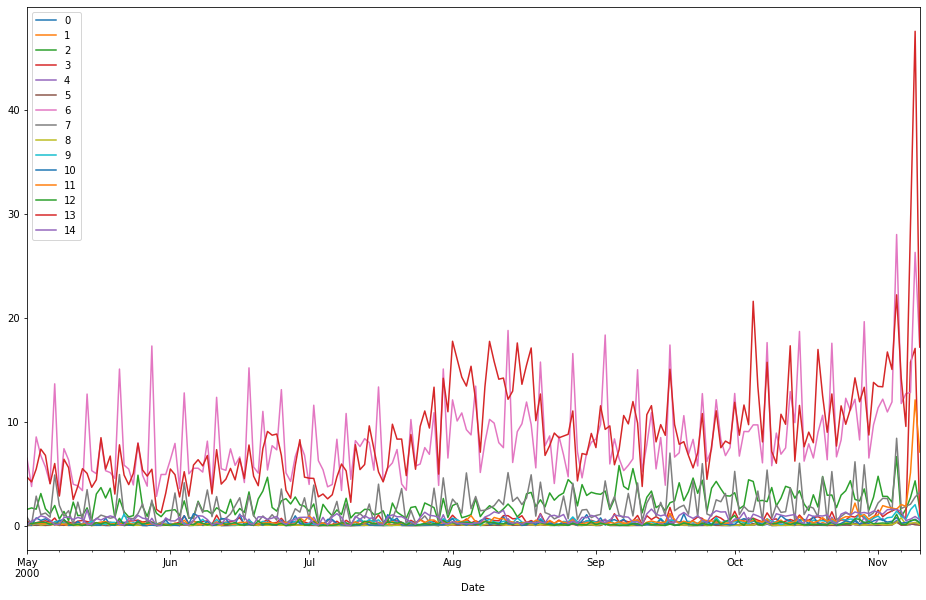

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.002974  0.023819  1.548600  0.442413  0.002974   
2000-05-02       0.504970  0.066477  0.072539  1.688473  0.125810  0.019826   
2000-05-03       0.509491  0.014457  0.074760  1.571724  0.271223  0.074371   
2000-05-04       0.511466  0.036063  0.034612  3.077083  0.353000  0.283786   
2000-05-05       0.520875  0.016924  0.022382  1.605204  0.456239  0.016511   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.008063  6.467272  0.800860  0.167299  0.086867  0.207906   
2000-05-02  0.009597  3.747971  0.135718  0.011597  0.146917  0.020422   
2000-05-03  0.031689  8.517492  2.824734  0.211972  0.162680  0.732440   
2000-05-04  0.014654  6.723929  1.045287  0.033422  0.162845  0.488093   
20

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17666293.771875735
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.012532  0.002974  0.008063  1.901199  0.537282  0.025516   
2000-05-02  0.009597  0.070874  0.015462  1.726047  0.298492  0.071184   
2000-05-03  0.039384  0.019251  0.084949  2.088022  0.576654  0.073372   
2000-05-04  0.017260  0.260369  0.017413  3.597079  0.539033  0.034134   
2000-05-05  0.041360  0.016428  0.013590  2.289406  0.651498  0.022380   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.044069  0.955730  0.298847  7.337349  0.760484  0.024110   
2000-05-02  0.023802  0.318674  0.049353  4.796738  0.564833  0.093894   
2000-05-03  0.626703  2.555368  0.531118  8.348454  0.813838  0.010849   
2000-05-04  0.163906  1.440307  0.2

<Figure size 1152x720 with 0 Axes>

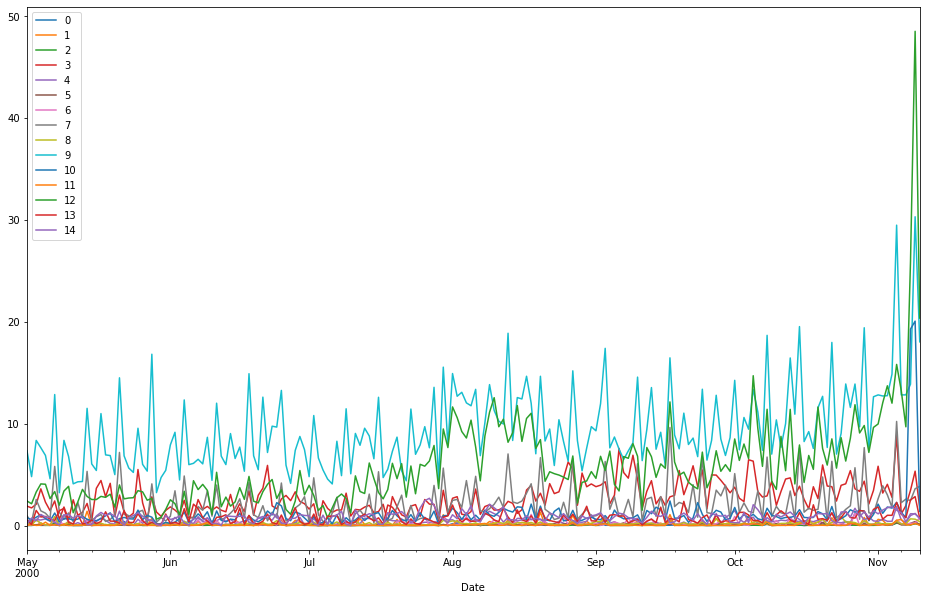

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.012532  0.002974  0.008063  1.901199  0.537282   
2000-05-02       0.504970  0.009597  0.070874  0.015462  1.726047  0.298492   
2000-05-03       0.509491  0.039384  0.019251  0.084949  2.088022  0.576654   
2000-05-04       0.511466  0.017260  0.260369  0.017413  3.597079  0.539033   
2000-05-05       0.520875  0.041360  0.016428  0.013590  2.289406  0.651498   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.025516  0.044069  0.955730  0.298847  7.337349  0.760484   
2000-05-02  0.071184  0.023802  0.318674  0.049353  4.796738  0.564833   
2000-05-03  0.073372  0.626703  2.555368  0.531118  8.348454  0.813838   
2000-05-04  0.034134  0.163906  1.440307  0.223928  7.630228  1.044815   
20

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17663817.013912406
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.002974  3.968427  1.614278  0.545891  0.022746  0.623226   
2000-05-02  0.009597  3.831778  1.688825  0.247897  0.071261  0.270451   
2000-05-03  0.010849  5.074748  1.591103  0.564771  0.103319  0.250565   
2000-05-04  0.019963  6.924232  2.937063  0.580113  0.034831  0.352251   
2000-05-05  0.011935  7.114764  1.398823  0.740340  0.025619  0.548693   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  6.146016  0.917970  0.920233  0.009804  0.005670  0.004910   
2000-05-02  3.978079  0.186024  0.469674  0.045768  0.009597  0.012560   
2000-05-03  8.981734  2.951798  0.783138  0.433080  0.025025  0.010849   
2000-05-04  7.428597  1.117849  1.0

<Figure size 1152x720 with 0 Axes>

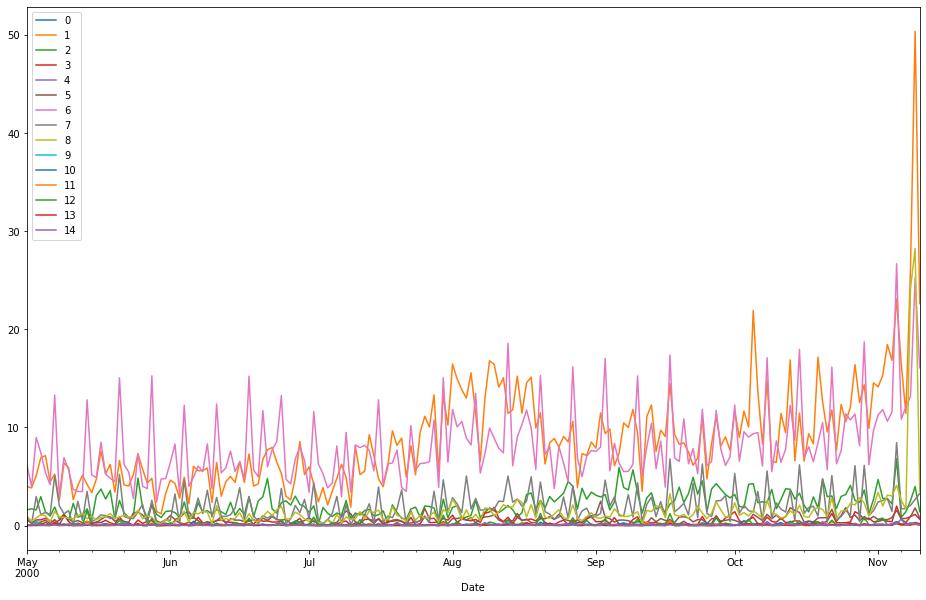

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.002974  3.968427  1.614278  0.545891  0.022746   
2000-05-02       0.504970  0.009597  3.831778  1.688825  0.247897  0.071261   
2000-05-03       0.509491  0.010849  5.074748  1.591103  0.564771  0.103319   
2000-05-04       0.511466  0.019963  6.924232  2.937063  0.580113  0.034831   
2000-05-05       0.520875  0.011935  7.114764  1.398823  0.740340  0.025619   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.623226  6.146016  0.917970  0.920233  0.009804  0.005670   
2000-05-02  0.270451  3.978079  0.186024  0.469674  0.045768  0.009597   
2000-05-03  0.250565  8.981734  2.951798  0.783138  0.433080  0.025025   
2000-05-04  0.352251  7.428597  1.117849  1.085095  0.164210  0.014654   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


89
[(11366, [500.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62611, [0, 314.52040496743723, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (33813, [0, 185.4795950325628, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (43386, [0, 0, 57.225513091256026, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (27993, [0, 0, 57.22170341486869, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (37602, [0, 0, 57.2122480265085, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (51934, [0, 0, 57.18276206619174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (40761, [0, 0, 57.14461402581571, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (36049, [0, 0, 57.00681743153073, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (49561, [0, 0, 56.63638319782509, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (19714, [0, 0, 55.264272954820065, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (24951, [0, 0, 45.10568579118344, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (52563, [0, 0, 0, 182.11264657917025, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (5321, [0, 0, 0, 169.29560098990697, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17688369.171518356
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.062688  0.018294  1.639343  0.022102  0.579943  0.094711   
2000-05-02  0.118147  0.029094  1.624662  0.071219  0.270852  0.020826   
2000-05-03  0.288150  0.019038  1.638979  0.083110  0.414536  0.546302   
2000-05-04  0.182563  0.469474  2.810769  0.034162  0.501049  0.040820   
2000-05-05  0.011935  0.019644  1.793622  0.022426  0.666831  0.035602   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.785958  0.083247  6.433096  0.006446  0.662549  0.016250   
2000-05-02  0.199312  0.033600  3.804809  0.009597  0.251068  0.009597   
2000-05-03  2.439322  0.178098  8.775435  0.079898  0.420613  0.026034   
2000-05-04  1.143884  0.115934  7.0

<Figure size 1152x720 with 0 Axes>

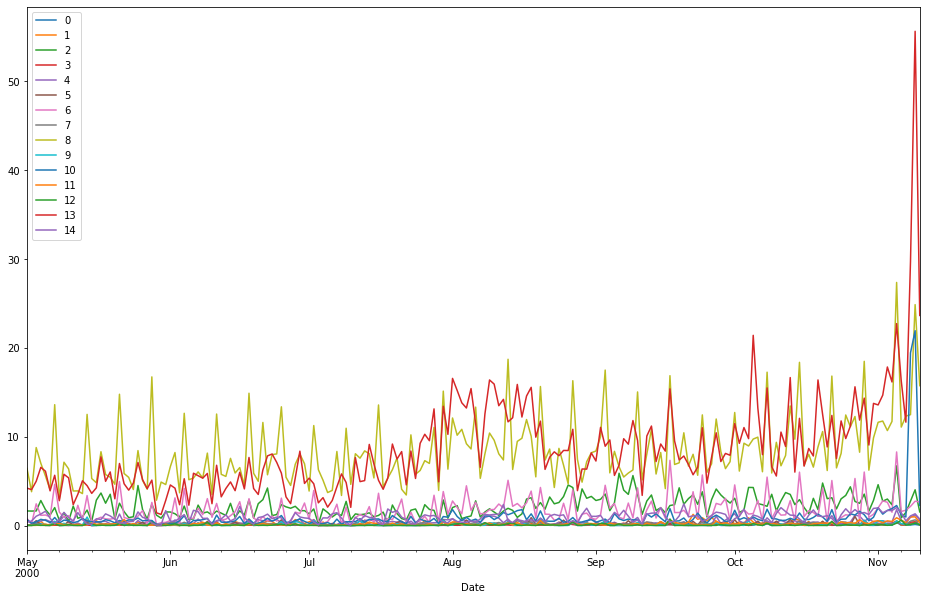

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.062688  0.018294  1.639343  0.022102  0.579943   
2000-05-02       0.504970  0.118147  0.029094  1.624662  0.071219  0.270852   
2000-05-03       0.509491  0.288150  0.019038  1.638979  0.083110  0.414536   
2000-05-04       0.511466  0.182563  0.469474  2.810769  0.034162  0.501049   
2000-05-05       0.520875  0.011935  0.019644  1.793622  0.022426  0.666831   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.094711  0.785958  0.083247  6.433096  0.006446  0.662549   
2000-05-02  0.020826  0.199312  0.033600  3.804809  0.009597  0.251068   
2000-05-03  0.546302  2.439322  0.178098  8.775435  0.079898  0.420613   
2000-05-04  0.040820  1.143884  0.115934  7.005768  0.130846  0.692333   
20

In [12]:
# Fit LDA model to feature vector
k = 15
count = 0
max_iterations = 1

prior_topic_words = []
#prior_topic_words.append((vocabulary.index('oil'), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
#print(prior_topic_words)

while (count < max_iterations):
    count+=1
    
    lda = PTW_LDA(n_components=15, learning_method='online', ptws=prior_topic_words)
    
    max_iterations = lda.max_iter

    lda.fit(ft_cv)

    print('log likelihood score, ' + str(k) + ' topics: ' + str(lda.score(ft_cv)))

    pyLDAvis.enable_notebook()
    p = pyLDAvis.sklearn.prepare(lda, ft_cv, cv)
    pyLDAvis.display(p)
    
    # Generate topic vs. word matrix
    # Note: the individual matrix values are pseudo counts NOT probabilities
    topic_word_matrix = pd.DataFrame((lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]), columns=vocabulary)
    print(topic_word_matrix.shape)

    # Generate document vs. topic coverage matrix
    lda_out = lda.transform(ft_cv)
    doc_topic_matrix = pd.DataFrame(lda_out)
    doc_topic_matrix['Date'] = main_df['Date']
    print(doc_topic_matrix.shape)

    # Aggregate topic coverages by each date and create topic_stream
    aggregator_topics = {i: 'sum' for i in range(k)}
    topic_stream = doc_topic_matrix.groupby(['Date']).agg(aggregator_topics)
    print(topic_stream.head())

    # Plot resulting topic streams
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.figure()
    topic_stream.plot()
    plt.show()
    
    # Prepare dem_data and topic_stream for Granger tests
    combined_topic_dem_data = pd.concat([dem_data, topic_stream], axis=1, join='inner')
    print(combined_topic_dem_data.head())
    print(pd.date_range(start='2000-05-01',end='2000-11-10').difference(combined_topic_dem_data.index))

    # Run Granger tests  against each topic and output the p values for F tests against each lag
    granger_topic_results = []

    for i in range(1,6):
            granger_topic_results.append([grangercausalitytests(combined_topic_dem_data[['NormLastPrice',j]],[i],verbose=False)[i][0]['ssr_ftest'][1] for j in range(k)])

    # Aggregate p values via mean to determine optimal lag
    granger_topic_df = pd.DataFrame(granger_topic_results)
    granger_topic_df.index = granger_topic_df.index + 1
    granger_topic_df['MeanP'] = granger_topic_df.mean(axis=1)
    granger_topic_df.sort_values(by=['MeanP'], inplace=True)
    optimal_lag = granger_topic_df.index[0]
    print(granger_topic_df)

    # With optimal lag, sort topics by p values in ascending order
    granger_topic_df.drop(['MeanP'], axis=1, inplace=True)
    topic_p_values = granger_topic_df.loc[optimal_lag].sort_values(ascending=True)

    # Check that output topics are <= 0.1... this is to give a bit of breathing room for topics boundary will be set at 0.05 for words
    top_topics = topic_p_values[topic_p_values<=0.1].index
    print(top_topics)
    
        # Choose l # of top words from top topic or max cumulative probability
    l = 25
    prob_m = 0.25

    # Choose mu value for prior pseudo count importance
    mu = 500

    topic = 0
    prior_topic_words = []
    # Sort significant topic by pseudo count in descending order
    for i in range(len(top_topics)):
        words_in_topic = topic_word_matrix.loc[top_topics[i]].sort_values(ascending=False)
        cumsum_words = words_in_topic.cumsum()
        #words_index = cumsum_words[cumsum_words <= prob_m].index ## use this only if wanting to use cumulative probabaility mass cutoff
        words_index = words_in_topic.index[:l]
    
        # Granger test on top l words for topic i
        granger_word_results = [grangercausalitytests(combined_word_dem_data[['NormLastPrice',words_index[j]]],[optimal_lag],verbose=False)[optimal_lag][0]['ssr_ftest'][1] for j in range(len(words_index))]
        granger_word_results = pd.Series(granger_word_results, index=words_index)
    
        # Pearson coefficient test on top l words for topic i
        pearson_word_results = combined_word_dem_data[words_index].corrwith(combined_word_dem_data['NormLastPrice'])
    
        # Check for only words w/ p values < 0.05
        granger_word_results = granger_word_results[granger_word_results < 0.05].sort_values(ascending=True)
        pearson_word_results = pearson_word_results[granger_word_results.index]
    
        # Count negative and positive words
        negative_words = (pearson_word_results<0).sum()
        positive_words = (pearson_word_results>0).sum()
    
        negative_bias = positive_words < negative_words*0.1
        positive_bias = negative_words < positive_words*0.1
    
        # If no words of topic met the criteria for p < 0.05 then skip to next iteration
        if negative_words == 0 and positive_words == 0:
            continue
    
        # If a topic is dominated negative OR positive then create priors for each word and assign to a single topic
        if negative_bias or positive_bias:
            if negative_bias: 
                pos_check = 0
                neg_check = 1
        
            if positive_bias: 
                pos_check = 1
                neg_check = 0
            
            priors = (1 - granger_word_results) - 0.95
        
            check = pearson_word_results
            check.loc[pearson_word_results>0] = pos_check
            check.loc[pearson_word_results<0] = neg_check
        
            priors = priors * check
            priors = priors/priors.sum()
            priors_index = priors.index
        
            for i in range(len(priors_index)):
                prior_array = [0]*k
                prior_array[topic] = priors[i]*mu
                prior_topic_words.append((vocabulary.index(priors_index[i]), prior_array))
            topic += 1
    
        # If a topic is both negative and positive w/ no dominance, split words into two topics and create priors for each topic
        else:
            transform_prior = (1 - granger_word_results) - 0.95
            temp_pos_prior = transform_prior[pearson_word_results>0]
            temp_neg_prior = transform_prior[pearson_word_results<0]
            
            pos_prior = temp_pos_prior/temp_pos_prior.sum()
            neg_prior = temp_neg_prior/temp_neg_prior.sum()
        
            pos_prior_index = pos_prior.index
            for i in range(len(pos_prior_index)):
                prior_array = [0]*k
                try:
                    prior_array[topic] = pos_prior[i]*mu
                except:
                    continue
                prior_topic_words.append((vocabulary.index(pos_prior_index[i]), prior_array))
        
            neg_prior_index = neg_prior.index
            for i in range(len(neg_prior_index)):
                prior_array = [0]*k
                try:
                    prior_array[topic+1] = neg_prior[i]*mu
                except:
                    continue
                prior_topic_words.append((vocabulary.index(neg_prior_index[i]), prior_array))
        
            topic += 2
            
    print(len(prior_topic_words))
    print(prior_topic_words)